# Syntactic Processing Assignment

For this assignment, you’ll use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 

You need to accomplish the following in this assignment:

Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

In [1]:
import nltk
from nltk.corpus import treebank, stopwords
import pandas as pd
from collections import Counter
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import UnigramTagger, BigramTagger
import numpy as np
import time
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot');

In [2]:
nltk.download('universal_tagset')
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/darkslayer/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /home/darkslayer/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/darkslayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/darkslayer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
corpus = list(treebank.tagged_sents(tagset='universal'))

In [4]:
corpus[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [5]:
# Getting number of sentences in the text
len(corpus) 

3914

In [6]:
# creating flatenned list of word, tag pair
flattened_corpus = [pair for sentence in corpus for pair in sentence]
flattened_corpus[:3]

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.')]

<pre>
As per documentation, this should contain 12 POS tags as given below:
`
The tagset consists of the following 12 coarse tags:

VERB - verbs (all tenses and modes)
NOUN - nouns (common and proper)
PRON - pronouns
ADJ - adjectives
ADV - adverbs
ADP - adpositions (prepositions and postpositions)
CONJ - conjunctions
DET - determiners
NUM - cardinal numbers
PRT - particles or other function words
X - other: foreign words, typos, abbreviations
. - punctuation

@see: http://arxiv.org/abs/1104.2086 and http://code.google.com/p/universal-pos-tags/

`

In [7]:
# Create array of tags from corpus 
tag_seq = [tag for word, tag in flattened_corpus]
set(tag_seq)

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

There are 12 unique POS tags in the dataset

In [8]:
# Create a frequency distribution of tags using Counter
counter = Counter(tag_seq)
# extracting msot commong tags 
counter.most_common(5)

[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]

In [9]:
# Unique Words in text
len(set([word for word, tag in flattened_corpus]))

12408

In [10]:
# Create a frequency distribution of words using Counter
counter = Counter([word.lower() for word, tag in flattened_corpus])

In [11]:
# extracting msot common words
counter.most_common(5)

[(',', 4885), ('the', 4764), ('.', 3828), ('of', 2325), ('to', 2182)]

All are stop words. Let's see the most common words after removing the stop words

We see it outputs digits or special characers, since they are not included in default stopwords dictionary. So we shall remove such words

In [12]:
eng_stopwords = stopwords.words('english')
eng_stopwords.extend(string.punctuation)
word_seq_nostopword = [word.lower() for word, tag in flattened_corpus if word not in eng_stopwords]

In [13]:
counter = Counter(word_seq_nostopword)

In [14]:
counter.most_common(5)

[('*-1', 1123), ('0', 1099), ("'s", 865), ('*t*-1', 806), ('*u*', 744)]

We see it outputs digits or special characers, since they are not included in default stopwords dictionary. Let's check what are these labelled as:

In [15]:
common_5 = [token for token, count in counter.most_common(5)]
list(filter(lambda x: x[0] in common_5, list(set(flattened_corpus))))

[('*-1', 'X'), ("'s", 'PRT'), ("'s", 'VERB'), ('0', 'X')]

Now given in the NLTK documentation, we can see that the `*-1`, `*U*` are tagged as `X` indicating these might be typos or foriegn words

## Split Data into train and validation set

Now let's split the data into test and training set

In [16]:
# split into training and validation set @ ratio of 95:5
train_set, validation_set = train_test_split(corpus, test_size=0.05, random_state=100)

In [17]:
# flatten the collection of training and validation sentences
flattened_train = [pair for sentence in train_set for pair in sentence]
flattened_validation = [pair for sentence in validation_set for pair in sentence]

In [18]:
# check lenth of training set/number of sentences
len(train_set)  

3718

In [19]:
# check length of validation set/number of sentences
len(validation_set)

196

In [20]:
# check ratio of training set
len(train_set) / len(corpus)

0.9499233520694941

So around 95% data is in training set and 5% is in validation set

### `Note: P(tag|word) = emission prob * transision prob`


## Calculating Emission and Transition Probabilities
### Emission Probabilities
Emission prob = P(word|tag) =  # occurence of the `word` with `tag` 
                                ---------------------------------------
                                      total # occurences of `tag`

In [21]:
# convert the flat training set into a dataframe of columns word and its tag
training = pd.DataFrame(flattened_train, columns=['word','tag'])
# convert the flat validation set into a dataframe of columns word and its tag
validation = pd.DataFrame(flattened_validation, columns=['word','tag'])

In [22]:
# CrossTabulation of the number of occurences of each word against each tag. This will give emission probability (eventually after division)
emission = pd.crosstab(training.word.apply(str.lower), training.tag)

Note: Right now we shall only calculate the emission counts of words for each tag. Probabilities will be calculated while prediction in Viterbi

### Transition Probabilities
Transition prob = P(tag t2 | tag t1) = # occurence of tag `t2` followed by tag `t1`
                                    --------------------------------------------------
                                            # occurence of tag `t2`

P(t2|word) = p(word|t2) * p(t2|t1)

1. t1 = prev tag
2. t2 = current tag to predict
3. word =  word in consideration

In [23]:
# construct a list of tags like [(t1, t2), (t2, t3), (t3, t4)....] to get pairs of adjacent tags
adjacent_tag_seq = [(flattened_train[index][1], flattened_train[index + 1][1]) for index in range(len((flattened_train)) - 1)]
# Convert the list to a dataframe
adjacent_tag_seq = pd.DataFrame(adjacent_tag_seq, columns=['tag1','tag2'])
# Cross Tabulation of number of occurence of each adjacent tag pair where tag 1 is followed by tag 2
transition = pd.crosstab(adjacent_tag_seq.tag1, adjacent_tag_seq.tag2)
transition.head()

tag2     .   ADJ   ADP  ADV  CONJ   DET  NOUN  NUM  PRON  PRT  VERB    X
tag1                                                                    
.     1036   487  1028  583   647  1935  2481  907   727   28   989  300
ADJ    390   410   480   30    98    30  4279  127     3   62    72  124
ADP    375  1013   165  126     8  3056  3030  584   652   14    80  330
ADV    406   391   359  232    21   210    95   95    47   43  1035   70
CONJ    77   256   116  116     1   256   756   91   126    8   335   19

In [24]:
# Divide each row by the toal occurence of current tag t2 AFTER TAG t1
for row in transition.index:
    transition.loc[row, :] = transition.loc[row, :] / transition.loc[row,:].sum()

** Now we shall start with Vanilla Viterbi algorithm**

In [25]:
'''
tag_seq = list of tags ordered as per word seq
word_seq = list of words in order
'''
def vanilla_viterbi(word_seq:list):
    # normalize the sequence
    word_seq = list(map(str.lower, word_seq))
    # Consider . as previous tag for first tag in sentence
    assigned_tag_seq = ['.']
    
    for word in word_seq:
        # element wise multiplcation of each row
        try:
            # remember emission is table of COUNT OF OCCURENCE of word as each tag while transition is table of PROBABILITIES itself so no need to divide by sum in transition
            prob = (emission.loc[word, :] / emission.sum()) * transition.loc['.', :]
        except KeyError:
            # If unknown word occurs, consider the probabilities for all tags for that word as 0
            prob = [0]*len(emission.columns)

        idx = list(prob).index(max(prob))
        tag_with_max_prob = list(emission.columns)[idx]
        assigned_tag_seq.append(tag_with_max_prob)
        
    return assigned_tag_seq[1:]

In [26]:
'''
Given a sequence of strings/message, predicts the Parts of Speech tags for each of the word in the sequence
'''
def predict_pos_tags(dataset, optimizer):
    predictions = []
    for sentence in dataset:
        # For each sentence S do as follows
        # initalize lists
        tokens, tags=[], []
        # Create a list of tokens and tags separately for the sentence S
        for token, tag in sentence:
            tokens.append(token)
            tags.append(tag)
        # Create a list predicted and correct tag for each word in the sentence S. Structure like [(word1, correct tag, predicted tag), (word2, correct tag, predicted tag), ......]
        predictions.append(list(zip(tokens, tags, optimizer(tokens))))
    
    return predictions

In [27]:
# Testing vanilla viterbi with dummy sentence
vanilla_viterbi(['customers','and', 'banks','have', 'good', 'relations'])

['NOUN', 'CONJ', 'NOUN', 'VERB', 'ADJ', 'NOUN']

In [28]:
# Mark start runtime
start_time = time.time()
# Start prediction on validation set
predictions = predict_pos_tags(validation_set, vanilla_viterbi)
# Mark end runtime
end_time = time.time()
# Calculate total runtime
vanilla_viterbi_runtime = end_time - start_time
# flatten the predictions as a list of tuples
flattened_pred = [pred for sentence in predictions for pred in sentence]

### Checking on test file
*Let's test the tagger in unknown test set. We shall import some sample test sentences*

In [29]:
# Open test file and store the content
with open('Test_sentences.txt', 'r') as file:
    test_sentences = file.readlines()

Now we will create a function to predict the tags on test sentences using the algorithm passed as argument

In [30]:
'''
Predicts tags in test sentences using the given optimizing function
'''
def test_sentence_prediction(optimizer):
    test_prediction = []
    # For each sentence S
    for sent in test_sentences:
        # Tokenize the sentence S
        tokens = word_tokenize(sent)
        # Add to the predictions a new list of token-tag pair like [(token1, predicted tag1), (token2, predicted tag2), ......]
        test_prediction.append(list(zip(tokens, optimizer(tokens))))
    return test_prediction

In [31]:
# Predicting on test sentence
test_prediction = test_sentence_prediction(vanilla_viterbi)
# Gather the predictions for test sentences as a dataframe
test_predictions_df = pd.DataFrame([pair for sent in test_prediction for pair in sent], columns=['Word','Prediction by Vanilla Viterbi'])
# Print a random sample of 30 rows
test_predictions_df.sample(30, random_state=40)

Word Prediction by Vanilla Viterbi
67      politics                          NOUN
5         system                          NOUN
161    afternoon                          NOUN
132         from                           ADP
178     ICESAT-2                             .
124       Europe                          NOUN
152          the                           DET
126         Show                          NOUN
35          that                           DET
174   experience                          NOUN
127           me                          PRON
26             .                             .
148           me                          PRON
129     cheapest                           ADJ
79             .                             .
119           it                          PRON
120          has                          VERB
37        Google                             .
28           and                          CONJ
23       tablets                          NOUN
140          see                          VERB
136            I                          PRON
85            is                          VERB
171        media                          NOUN
18   smartphones                             .
162          and                          CONJ
106        World                          NOUN
155      Atlanta                          NOUN
154      leaving                          VERB
42      firehose                             .

### It is evident the tagger is not performing well on the test set. There are several words like Google, smartphones, ICESAT-2 and firehose which are not tagged correctly by the Vanilla Viterbi algorithm. Also, it is worth noticing that as a fallback, vanilla Viterbi tags unknown words as '.' as its last measure. 

## Evaluating the Vanilla Viterbi
In order to calculate the accuracy of our POS Tagging algorithm, we will create a function for the same.

In [32]:
'''
Tests accuracy of a set of predictions. Accepts a list of (word, tag, predicted tag)
'''
def accuracy(predictions):
    count = 0
    # Flatten the given predictions list
    flattened_pred = [item for sent in predictions for item in sent]
    # Create a separate list of predicted tags
    predicted_tags = [item[2] for item in flattened_pred]
    # Create a separate list of true/correct tags
    true_tags = [item[1] for item in flattened_pred]
    # Count the occurences where true tag doesnt match predicted tag
    for idx in range(len(predicted_tags)):
        if predicted_tags[idx] == true_tags[idx]:
            count+=1
            
    return round(count / len(predicted_tags)*100, 3)

In [33]:
# Compute accuracy of vanilla viterbi algorithm
vanilla_viterbi_accuracy = accuracy(predictions)

print('Runtime for Vanilla Viterbi is {}'.format(vanilla_viterbi_runtime))
print('Accuracy with Vanilla Viterbi is {}'.format(vanilla_viterbi_accuracy))

Runtime for Vanilla Viterbi is 4.903326988220215
Accuracy with Vanilla Viterbi is 89.021


We see we have got an accuracy of 89% in the Vanilla Viterbi algorithm taking the greedy approach. However, let's try to improve this a little further.<br/>
***For improvement, we shall first analyze the words from the english language itself and try to find some patterns in it.***

## Analyzing patterns in words
Let's now analyse the words individually from the experience of the English language itself and try to form some rules based on the general patterns in words.
So we shall try to come up with a pattern and then check out the proportion of the word being tagged as some tag T in the training data.

First, let's construct a handy function for our needs

In [34]:
'''
Given a regex pattern and tag, find out the proportion of words satisfying that pattern for the tag
'''
def pattern_proportion(pattern, tags, tagged_words, show_words=False, show_dist=False):
    # Create a list of (word, tag) pair where the word matches the given pattern
    pattern_match= list(filter(lambda x: re.match(pattern, x[0].strip()), tagged_words))
    # Extract unique pattern matches since there can be duplicates
    unique_pattern_matches = set([word for word, tag in pattern_match])

    # If tags is a list
    if type(tags) == list:
        # Create an empty series
        sr = pd.Series([0]*len(tags),index=tags)
    
        for tag in tags:
            # Extract the words which have the tag 'tag' from the list of pattern matching pairs 
            matching_words =  [word for word, t in pattern_match if t == tag.upper()]
            # Set value of the tag with its proportion in all tags for the words with pattern
            sr.loc[tag]= round(len(set(matching_words)) / len(unique_pattern_matches)*100, 2)
            # If show words display the words list for the tag
            if show_words:
                print(tag+': '+str(set(matching_words)))
        # if show_dist, show bar plot of the tag distribution of the words matching the pattern
        if show_dist: 
            sns.barplot(x=sr.index, y=sr.values)

        return sr
    # If tag is single string
    else:
        # Extract the words which have the tag 'tag' from the list of pattern matching pairs 
        matching_words =  [word for word, tag in pattern_match if tag == tags.upper()]
        # if show_dist, show bar plot of the tag distribution of the words matching the pattern
        if show_dist: 
            sns.barplot(matching_words)
        # Return proportion of the tag among all tags 
        return round(len(set(matching_words)) / len(unique_pattern_matches)*100, 2)

With the function in place, we can start analyzing the patterns in words and **form some rules for identifying correct Parts of Speech tags**, starting with verbs:

In [35]:
# Display proportion of words ending with ing as VERB
print(pattern_proportion('.*ing$', 'VERB', flattened_train))

70.8


We see around 58% of the words ending with 'ing' are actually Verbs. This can be used as a rule.
> Rule 1: Tag words ending with 'ing' as VERB

In [36]:
# Display proportion of words ending with 'ed' as VERB
pattern_proportion('.*ed$', 'VERB', flattened_train)

79.52

Again almost all words ending with 'ed' are tagged as VERB.
> Rule 2: Tag words ending with 'ed' as VERB

Ley's check the distribution of different POS tagss for the words in title case

NOUN    87.57
ADJ      6.16
DET      0.60
X        0.07
dtype: float64

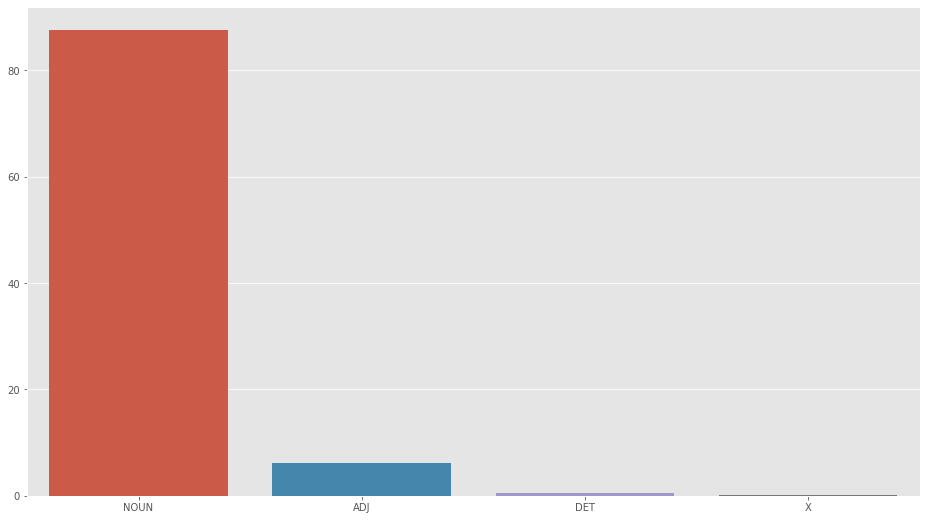

In [37]:
# Display proportion of words in title case as NOUN, ADJ, DET, X
pattern_proportion('[A-Z][a-z]+', ['NOUN','ADJ','DET','X'], flattened_train, show_dist=True)

So 87% of the words starting with capital letter are actually NOUN.
> Rule 3: Tag words in Titlecase as NOUN

Now let's analyze the modals and check for wordws like 'would'.

In [38]:
# Display proportion of words ending with 'ould' for each tag
pattern_proportion('.*ould$', list(set(tag_seq)), flattened_train)

CONJ      0
NOUN      0
PRT       0
.         0
ADJ       0
VERB    100
DET       0
PRON      0
X         0
ADP       0
ADV       0
NUM       0
dtype: int64

Interestingly all words ending with 'ould' are verbs, since these are words like should, could, would.
> Rule 4: Tag words ending with 'ould' as VERBS

CONJ     0
NOUN    96
PRT      0
.        0
ADJ      4
VERB     0
DET      0
PRON     0
X        0
ADP      0
ADV      0
NUM      0
dtype: int64

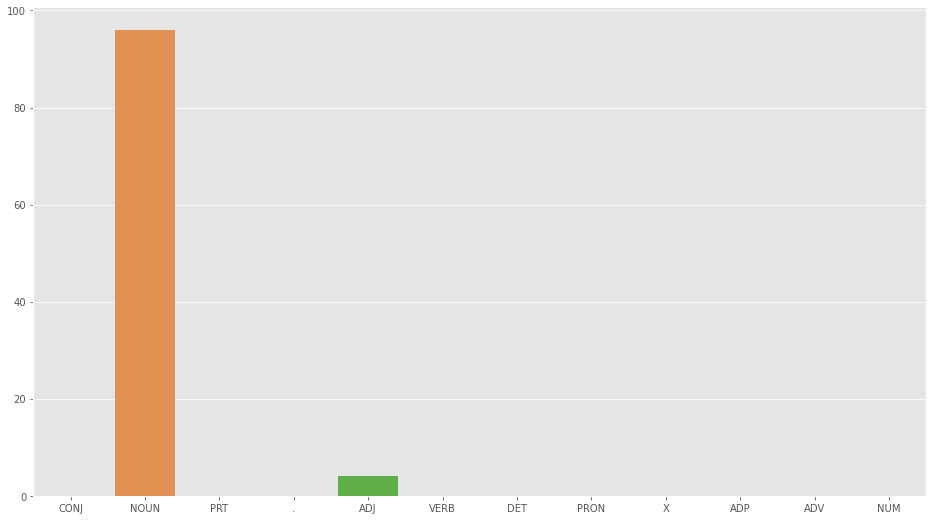

In [39]:
# Display proportion of words ending with 'ness' for each tag. Show the bar graph for each tag as well
pattern_proportion('.*ness$', list(set(tag_seq)),flattened_train, show_dist=True)

All words ending with 'ness' are NOUN  since these are words like kindness, wellness, etc which are noun form of an adjective.
> Rule 5: Tag words ending with 'ness' as ADJ

Now typically we come across words in English like highest, bes, lowest, etc which are superlative forms of the adjectives. So let's check this pattern

NOUN: {'Midwest', 'test', 'Norwest', 'request', 'guest', 'achievement-test', 'harvest', 'Univest', 'protest', 'behest', 'incest', 'Test', 'West', 'rest', 'interest'}
VERB: {'contest', 'arrest', 'suggest', 'divest', 'invest', 'test'}
ADJ: {'longest', 'third-highest', 'loveliest', 'largest', 'second-largest', 'oldest', 'latest', 'fastest', 'dirtiest', 'busiest', 'biggest', 'strongest', 'modest', 'hottest', 'student-test', 'best', 'greatest', 'earliest', 'brightest', 'highest', 'lowest', 'loudest', 'newest', 'priciest', 'cheapest', 'smallest', 'West'}


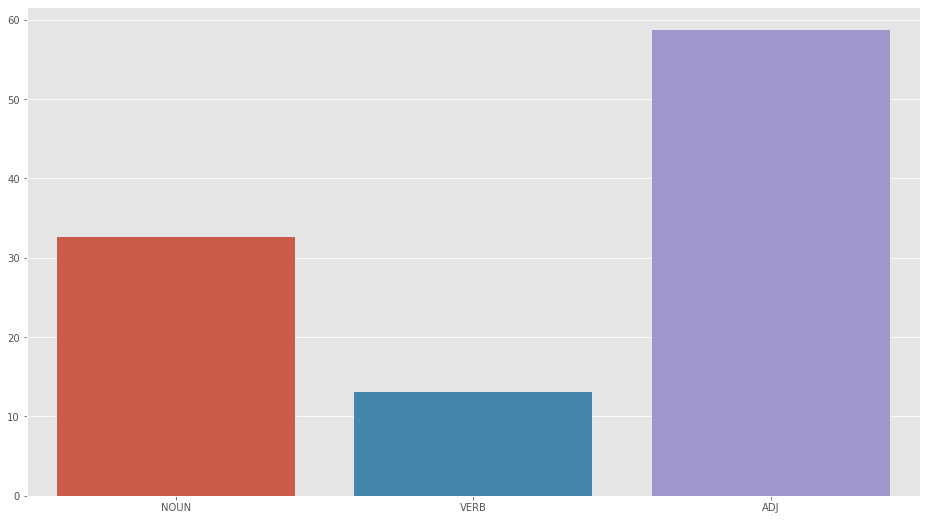

In [40]:
# Display proportion of words ending with 'est' for NOUN, VERB, ADJ. Show the bar graph and words for each tag as well
pattern_proportion('.*est$',['NOUN','VERB','ADJ'],flattened_train, show_words=True, show_dist=True);

So we can see significant amount of words ending with 'est' are adjectives. Relatively, equal number of NOUN are also there. However for simplicity, we shall take this rule:
> Rule 6: Tag words ending with 'est' as ADJ

Now there are words in language like hardened, sweetened, etc which are past form of words. Let's check this intution

NOUN: set()
VERB: {'frightened', 'lengthened', 'brightened', 'heightened', 'opened', 'screened', 'reopened', 'happened', 'threatened', 'tightened', 'sweetened', 'fattened', 'strengthened'}
ADJ: {'Heightened'}


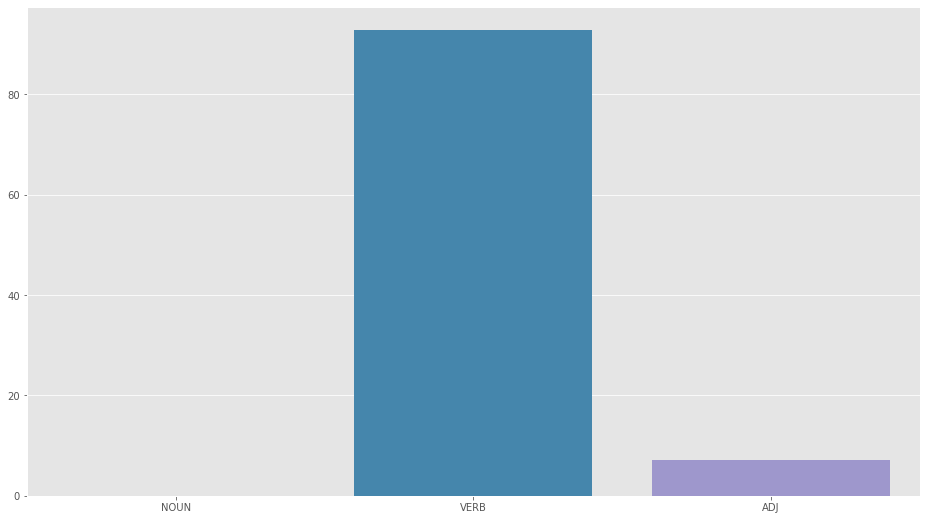

In [41]:
# Display proportion of words ending with 'ened' for NOUN, VERB, ADJ. Show the bar graph as well
pattern_proportion('.*ened$',['NOUN','VERB','ADJ'],flattened_train,show_dist=True, show_words=True);

Interestingly, almost all words ending with 'ened' are VERBS as per the training data.
> Rule 7: Tag words ending with 'ened' as VERB

Now, there is a soft observation of words ending with 'ly' typically occuring throughout the  language like occasionally, typically, fully, etc. Let's check if such words have POS tags also in common

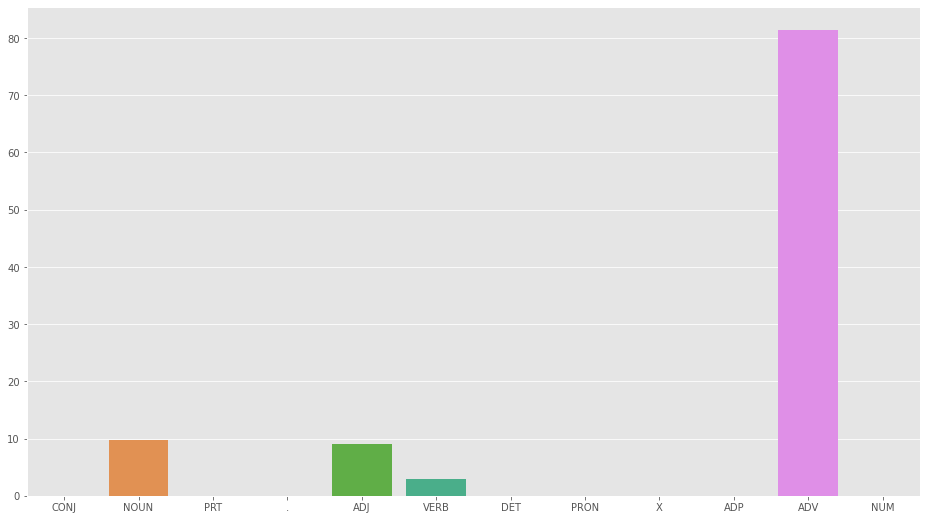

In [42]:
# Display proportion of words ending with 'ly' for each tag. Show the bar graph and words for each tag as well
pattern_proportion('.*ly',list(set(tag_seq)),flattened_train, show_dist=True);

Interestingly, this small observation has been fruitful and resulted in 87% of the words ending with -ly are Adverbs. 
> Rule 8: Tag words ending with 'ly' as ADV

CONJ     0.00
NOUN    28.00
PRT      0.00
.        0.00
ADJ     53.33
VERB     2.67
DET      0.00
PRON     0.00
X        0.00
ADP      0.00
ADV     16.00
NUM      1.33
dtype: float64

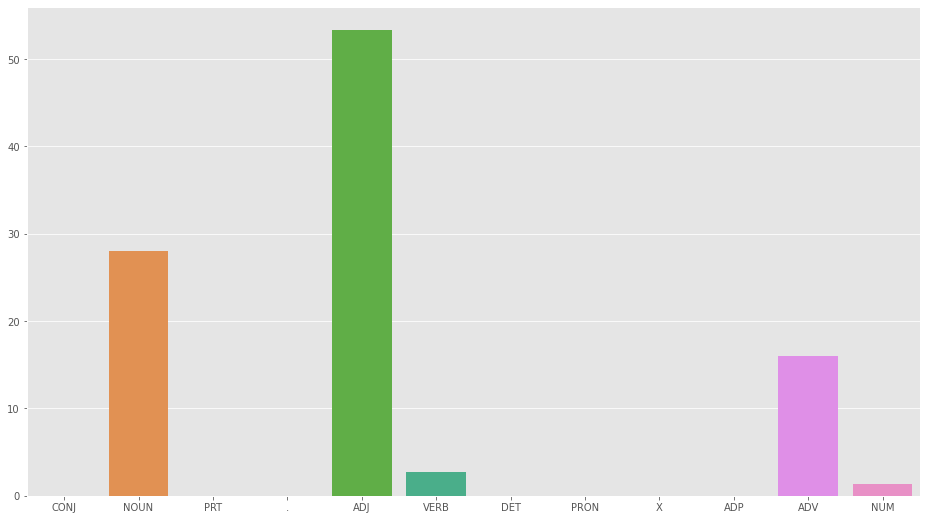

In [43]:
# Display proportion of words ending with 'ous' for each tag. Show the bar graph for each tag as well
pattern_proportion('.*ous',list(set(tag_seq)),flattened_train, show_dist=True)

> Rule 9: Tag words ending with 'ous' as ADJ.

Now that we are analysing adjectives, there are some of them which end with 'ive' like collective. So let's check such words

CONJ     0.00
NOUN    30.41
PRT      0.00
.        0.00
ADJ     47.37
VERB    17.54
DET      0.00
PRON     0.00
X        0.00
ADP      0.00
ADV      7.02
NUM      0.58
dtype: float64

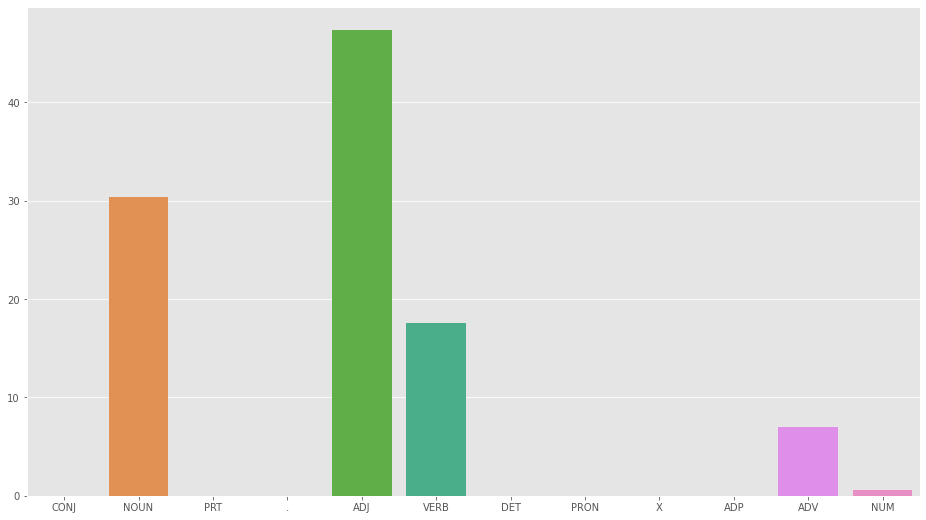

In [44]:
# Display proportion of words ending with 'ive' for each tag. Show the bar graph for each tag as well
pattern_proportion('.*ive',list(set(tag_seq)),flattened_train, show_dist=True)

> Rule 10: Tag words ending with 'ive' as Adjective.

Now there are words ending with 'ment' like judgement, torment, etc. which we know are nouns. Let's check this theory as well.

CONJ     0.00
NOUN    80.26
PRT      0.00
.        0.00
ADJ     13.16
VERB     6.58
DET      0.00
PRON     0.00
X        0.00
ADP      0.00
ADV      1.32
NUM      0.00
dtype: float64

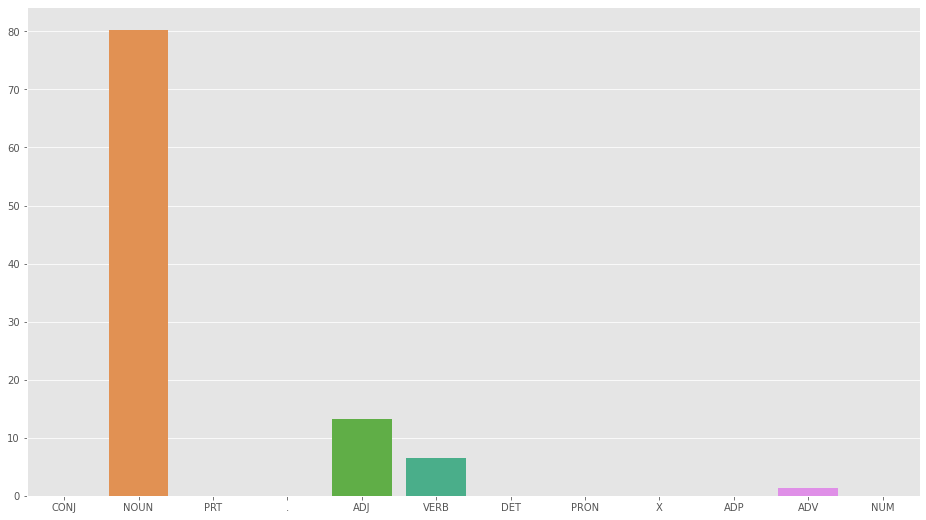

In [45]:
# Display proportion of words ending with 'ment' for each tag. Show the bar graph for each tag as well
pattern_proportion('.*ment',list(set(tag_seq)),flattened_train, show_dist=True)

80% of the words ending with 'ment' are actually NOUN. So we stand with the theory.
>Rule 11: Tag word ending with 'ment' as NOUN

### Checking Lexicon Taggers and their ability as fallback
Now with the rules set above, we shall try to use them to create fallback tagger ourself along with other n-gram taggers


In [46]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),                # present continuous verbs / gerund
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'^[A-Z][a-z]+', 'NOUN'),          # Title case words
    (r'.*ould$', 'VERB'),               # modals / modal verbs
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*est$', 'ADJ'),                 # adjectives in superlative degree
    (r'.*ened$', 'VERB'),               # verbs like hardened
    (r'.*ly$', 'ADV'),                  # adverbs like occasionally
    (r'.*ous', 'ADJ'),                  # Adjectives like delicious
    (r'.*ive', 'ADJ'),                  # Adjectives like collective
    (r'.*es$', 'VERB'),                 # present tense verbs
    (r'.*ment', 'NOUN'),                # nouns like judgement
    (r'.*\'s$', 'NOUN'),                # possessive nouns like Ramesh's, Suresh's
    (r'.*s$', 'NOUN'),                  # plural noun
    (r'^[0-9]+$', 'NUM'),               # Numbers
    (r'^for$|^and$|^nor$|^but$|^or$|^yet$|^so$', 'CONJ'),           # conjunction
    (r'\.|,|:|;|!|\?', '.'),            # phrase terminators
    (r'.*', 'NOUN')                     # fallback, label everything not matching above as noun
]

In [47]:
# Create a unigram tagger and test on validation set
uni = UnigramTagger(train_set)
round(uni.evaluate(validation_set) * 100, 2)

90.14

So we see a Unigram Tagger is giving accuracy of 90%.

In [48]:
# Create a biigram tagger and test on validation set
bi = BigramTagger(train_set)
round(bi.evaluate(validation_set) * 100, 2)

21.51

However, as expected, the BiGram Tagger is having a lower accuracy of only 21%. This is explained since the two pair of words occuring together in training data will not be occuring on the test data together.

*Let's try a tagger with the rules we have concluded after analysis*

In [49]:
# Create a pattern tagger and test on validation set
regexp = nltk.RegexpTagger(patterns)
round(regexp.evaluate(validation_set) * 100, 2)

44.91

The simple rule based tagger is also performing average. So **let's try combining all lexicon taggers** 

In [50]:
# Create a combined tagger with back off rules and test on validation set
uni = UnigramTagger(train_set, backoff=regexp)
bi = BigramTagger(train_set, backoff=uni)

In [51]:
round(bi.evaluate(validation_set) * 100, 2)

94.58

So we have now got an accuracy of 94.5%  which is greater than any of the lexicon tagger individually.
### We shall use these lexicon taggers  as a way to improve the probabilistic tagger, HMM + Viterbi, for unknown words

## Modifying Viterbi: Using Laplace Smoothing for Unknown Words

In [52]:
'''
tag_seq = list of tags ordered as per word seq
word_seq = list of words in order
'''
def viterbi_with_laplace_smoothing(word_seq:list):
    # normalize the sequence
    word_seq = list(map(str.lower, word_seq))
    # Consider . as previous tag for first tag in sentence    
    assigned_tag_seq = ['.']
    
    for idx, word in enumerate(word_seq):
        # element wise multiplcation of each row
        try:
            # remember emission is table of COUNT OF OCCURENCE of word as each tag while transition is table of PROBABILITIES itself so no need to divide by sum in transition
            prob = (emission.loc[word, :] / emission.sum()) * transition.loc['.', :]
        except KeyError:
            # Laplace Smoothing on emission probability: Using a very small probability value so that the product does not become 0
            prob = (1 / (emission.sum() + emission.shape[0])) * transition.loc['.', :]
        # Calculating the tag with maximum probability
        max_prob = max(prob)
        
        idx = list(prob).index(max(prob))
        tag_with_max_prob = list(emission.columns)[idx]
        # Adding to list of tags for sentence
        assigned_tag_seq.append(tag_with_max_prob)

    return assigned_tag_seq[1:]

In [53]:
# Mark start runtime
start_time = time.time()
# Start prediction on validation set with laplace smoothing
predictions = predict_pos_tags(validation_set, viterbi_with_laplace_smoothing)
# Mark end runtime
end_time = time.time()
# Calculate total runtime
viterbi_with_laplace_smoothing_runtime = end_time - start_time
# Calculate accuracy of Viterbi with Laplace smoothing
viterbi_with_laplace_smoothing_accuracy = accuracy(predictions)

print('Runtime for Viterbi with Laplace Smoothing is {}'.format(viterbi_with_laplace_smoothing_runtime))
print('Accuracy of Viterbi with Laplace Smoothing is {}'.format(viterbi_with_laplace_smoothing_accuracy))

Runtime for Viterbi with Laplace Smoothing is 4.945362329483032
Accuracy of Viterbi with Laplace Smoothing is 89.042


Now let's check if our modification has improved our prediction of unknown test sentences from the file

In [54]:
# Predicting on test sentence
test_prediction = test_sentence_prediction(viterbi_with_laplace_smoothing)
# Create a new column for results of tagging by Viterbi with Laplace smoothing
test_predictions_df['Predicted tag by Viterbi Laplace Smoothing'] = [tag for sent in test_prediction for word, tag in sent]
# Create a new column for results of tagging by Viterbi without emission probability for unknown words
test_predictions_df.sample(30, random_state = 40)

Word Prediction by Vanilla Viterbi  \
67      politics                          NOUN   
5         system                          NOUN   
161    afternoon                          NOUN   
132         from                           ADP   
178     ICESAT-2                             .   
124       Europe                          NOUN   
152          the                           DET   
126         Show                          NOUN   
35          that                           DET   
174   experience                          NOUN   
127           me                          PRON   
26             .                             .   
148           me                          PRON   
129     cheapest                           ADJ   
79             .                             .   
119           it                          PRON   
120          has                          VERB   
37        Google                             .   
28           and                          CONJ   
23       tablets                          NOUN   
140          see                          VERB   
136            I                          PRON   
85            is                          VERB   
171        media                          NOUN   
18   smartphones                             .   
162          and                          CONJ   
106        World                          NOUN   
155      Atlanta                          NOUN   
154      leaving                          VERB   
42      firehose                             .   

    Predicted tag by Viterbi Laplace Smoothing  
67                                        NOUN  
5                                         NOUN  
161                                       NOUN  
132                                        ADP  
178                                        DET  
124                                       NOUN  
152                                        DET  
126                                       NOUN  
35                                         DET  
174                                       NOUN  
127                                       PRON  
26                                           .  
148                                       PRON  
129                                        ADJ  
79                                           .  
119                                       PRON  
120                                       VERB  
37                                         DET  
28                                        CONJ  
23                                        NOUN  
140                                       VERB  
136                                       PRON  
85                                        VERB  
171                                       NOUN  
18                                         DET  
162                                       CONJ  
106                                       NOUN  
155                                       NOUN  
154                                       VERB  
42                                         DET

We can now see that all the words like *Google, smarphones firehose* etc which were previously not tagged correctly are now tagged as 'DET'. So again it is resulting into a default tag, previously it was '.', now it is 'DET'. So **not great improvement, and thus the similar accuracy result.**

We will now try to use another modification **using lexicon taggers as fallback mechanism**

## Modifying Viterbi: Using Lexicon Taggers for Unknown Words
To use lexicon taggers as fallback, let's prepare a function to do lexicon based tagging and modified version of Viterbi as well.


In [55]:
'''
Computes and returns the tag for the word at word_position, given the word sequence and a pattern for pattern based tagger
Uses Bigram tagger with Unigram tagger as its fallback which has a Pattern based tagger as its own fallback
'''
def lexicon_tagging(patterns:list, sequence: list, word_position: int):
    # fallback for unigram tagger with custom regex rules
    regexp = nltk.RegexpTagger(patterns)
    regexp.evaluate(validation_set)
    # fallback for bigram tagger with regex tagger as its own fallback
    uni = UnigramTagger(train_set, backoff=regexp)
    # bigram tagger
    bi = BigramTagger(train_set, backoff=uni)
    # predict tags  
    pred = bi.tag(sequence)
    return [tag for word, tag in pred][word_position]

We will use this tagger if there is any unknown word i.e. probabilities of the word having any of the tags is 0.

In [56]:
'''
tag_seq = list of tags ordered as per word seq
word_seq = list of words in order
'''
def viterbi_with_lexicon_taggers(word_seq:list):
    # normalize the sequence
    word_seq = list(map(str.lower, word_seq))
    
    assigned_tag_seq = ['.']
    
    for idx, word in enumerate(word_seq):
        # element wise multiplcation of each row
        try:
            prob = (emission.loc[word, :] / emission.sum()) * transition.loc['.', :]
        except KeyError:
            prob = [0]*len(emission.columns)
        max_prob = max(prob)
        if max_prob == 0:
            # unknown word since it is having probability of every tag as 0
            # invoke lexicon taggers    
            assigned_tag_seq.append(lexicon_tagging(patterns, word_seq, idx))
        else:
            # Calculating the tag with maximum probability
            idx = list(prob).index(max(prob))
            tag_with_max_prob = list(emission.columns)[idx]
            # Adding to list of tags for sentence
            assigned_tag_seq.append(tag_with_max_prob)
            
    return assigned_tag_seq[1:]

Now we can predict the tags for the test sequence again

In [57]:
# Mark start runtime
start_time = time.time()
# Start prediction on validation set with lexicon taggers
predictions = predict_pos_tags(validation_set, viterbi_with_lexicon_taggers)
# Mark end runtime
end_time = time.time()
# Calculate the total runtime
viterbi_with_lexicon_taggers_runtime = end_time - start_time
# Calculate accuracy of Viterbi with lexicon taggers
viterbi_with_lexicon_taggers_accuracy = accuracy(predictions)

print('Runtime for Viterbi with Lexicon Taggers is {}'.format(viterbi_with_lexicon_taggers_runtime))
print('Accuracy of Viterbi with Lexicon Taggers is {}'.format(viterbi_with_lexicon_taggers_accuracy))

Runtime for Viterbi with Lexicon Taggers is 738.4851257801056
Accuracy of Viterbi with Lexicon Taggers is 92.786


Let's now check if our modification has improved our prediction

In [58]:
# Predicting on test sentence
test_prediction = test_sentence_prediction(viterbi_with_lexicon_taggers)
# Create a new column for results of tagging by Viterbi and Lexicon tagger combination
test_predictions_df['Predicted tag by Viterbi & Lexicon tagger'] = [tag for sent in test_prediction for word, tag in sent]
# Display 30 samples from the table
test_predictions_df.sample(30, random_state=40)

Word Prediction by Vanilla Viterbi  \
67      politics                          NOUN   
5         system                          NOUN   
161    afternoon                          NOUN   
132         from                           ADP   
178     ICESAT-2                             .   
124       Europe                          NOUN   
152          the                           DET   
126         Show                          NOUN   
35          that                           DET   
174   experience                          NOUN   
127           me                          PRON   
26             .                             .   
148           me                          PRON   
129     cheapest                           ADJ   
79             .                             .   
119           it                          PRON   
120          has                          VERB   
37        Google                             .   
28           and                          CONJ   
23       tablets                          NOUN   
140          see                          VERB   
136            I                          PRON   
85            is                          VERB   
171        media                          NOUN   
18   smartphones                             .   
162          and                          CONJ   
106        World                          NOUN   
155      Atlanta                          NOUN   
154      leaving                          VERB   
42      firehose                             .   

    Predicted tag by Viterbi Laplace Smoothing  \
67                                        NOUN   
5                                         NOUN   
161                                       NOUN   
132                                        ADP   
178                                        DET   
124                                       NOUN   
152                                        DET   
126                                       NOUN   
35                                         DET   
174                                       NOUN   
127                                       PRON   
26                                           .   
148                                       PRON   
129                                        ADJ   
79                                           .   
119                                       PRON   
120                                       VERB   
37                                         DET   
28                                        CONJ   
23                                        NOUN   
140                                       VERB   
136                                       PRON   
85                                        VERB   
171                                       NOUN   
18                                         DET   
162                                       CONJ   
106                                       NOUN   
155                                       NOUN   
154                                       VERB   
42                                         DET   

    Predicted tag by Viterbi & Lexicon tagger  
67                                       NOUN  
5                                        NOUN  
161                                      NOUN  
132                                       ADP  
178                                      NOUN  
124                                      NOUN  
152                                       DET  
126                                      NOUN  
35                                        DET  
174                                      NOUN  
127                                      PRON  
26                                          .  
148                                      PRON  
129                                       ADJ  
79                                          .  
119                                      PRON  
120                                      VERB  
37                                       NOUN 

We can see there is significant improvement over the last two versions of `Viterbi algorithm in this version using lexicon tagger along with HMM`. The words *Google, ICESAT-2, firehose* all were tagged correctly as 'NOUN' instead of a default tag 'DET'. This is not random assignment as had it been the similar case like 'DET', *smartphones* would also have been tagged as 'NOUN', but rather the rules are taking initiative and tagged *smartphones* as 'VERB' (although it's incorrect tag).

Regardless, **there is an improvement in this version of Viterbi for tagging unknown words**. We shalll try one more variation of `Viterbi- using only transition probability for unknown words`

## Modifying Viterbi: Using Emission probability as '1' / only transition probability for Unknown words

In [59]:
'''
tag_seq = list of tags ordered as per word seq
word_seq = list of words in order
'''
def viterbi_with_emission_one(word_seq:list):
    # normalize the sequence
    word_seq = list(map(str.lower, word_seq))
    
    assigned_tag_seq = ['.']
    
    for idx, word in enumerate(word_seq):
        # element wise multiplcation of each row
        try:
            prob = (emission.loc[word, :] / emission.sum()) * transition.loc['.', :]
        except KeyError:
            # use only transition probability as the probability of the tag beign assigned to given word
            prob = transition.loc['.', :]
        # Calculating the tag with maximum probability
        max_prob = max(prob)
        
        idx = list(prob).index(max(prob))
        tag_with_max_prob = list(emission.columns)[idx]
        # Adding to list of tags for sentence
        assigned_tag_seq.append(tag_with_max_prob)

    return assigned_tag_seq[1:]

In [60]:
# Mark start runtime
start_time = time.time()
# Start prediction on validation set with only transition probability
predictions = predict_pos_tags(validation_set, viterbi_with_emission_one)
# Mark end runtime
end_time = time.time()
# Calculate total runtime
viterbi_with_emission_one_runtime = end_time - start_time
# Calculate accuracy of Viterbi with only transition probability
viterbi_with_emission_one_accuracy = accuracy(predictions)

print('Runtime for Viterbi with Emission One is {}'.format(viterbi_with_emission_one_runtime))
print('Accuracy of Viterbi with Emission One is {}'.format(viterbi_with_emission_one_accuracy))

Runtime for Viterbi with Emission One is 3.0043535232543945
Accuracy of Viterbi with Emission One is 91.898


In [61]:
# Predicting on test sentence
test_prediction = test_sentence_prediction(viterbi_with_emission_one)
# Create a new column for results of tagging by Viterbi without emission probability for unknown words
test_predictions_df['Predicted tag by Viterbi without Emission prob'] = [tag for sent in test_prediction for word, tag in sent]
# Display 30 samples from the table
test_predictions_df.sample(30, random_state=40)

Word Prediction by Vanilla Viterbi  \
67      politics                          NOUN   
5         system                          NOUN   
161    afternoon                          NOUN   
132         from                           ADP   
178     ICESAT-2                             .   
124       Europe                          NOUN   
152          the                           DET   
126         Show                          NOUN   
35          that                           DET   
174   experience                          NOUN   
127           me                          PRON   
26             .                             .   
148           me                          PRON   
129     cheapest                           ADJ   
79             .                             .   
119           it                          PRON   
120          has                          VERB   
37        Google                             .   
28           and                          CONJ   
23       tablets                          NOUN   
140          see                          VERB   
136            I                          PRON   
85            is                          VERB   
171        media                          NOUN   
18   smartphones                             .   
162          and                          CONJ   
106        World                          NOUN   
155      Atlanta                          NOUN   
154      leaving                          VERB   
42      firehose                             .   

    Predicted tag by Viterbi Laplace Smoothing  \
67                                        NOUN   
5                                         NOUN   
161                                       NOUN   
132                                        ADP   
178                                        DET   
124                                       NOUN   
152                                        DET   
126                                       NOUN   
35                                         DET   
174                                       NOUN   
127                                       PRON   
26                                           .   
148                                       PRON   
129                                        ADJ   
79                                           .   
119                                       PRON   
120                                       VERB   
37                                         DET   
28                                        CONJ   
23                                        NOUN   
140                                       VERB   
136                                       PRON   
85                                        VERB   
171                                       NOUN   
18                                         DET   
162                                       CONJ   
106                                       NOUN   
155                                       NOUN   
154                                       VERB   
42                                         DET   

    Predicted tag by Viterbi & Lexicon tagger  \
67                                       NOUN   
5                                        NOUN   
161                                      NOUN   
132                                       ADP   
178                                      NOUN   
124                                      NOUN   
152                                       DET   
126                                      NOUN   
35                                        DET   
174                                      NOUN   
127                                      PRON   
26                                          .   
148                                      PRON   
129                                       ADJ   
79                                          .   
119                                      PRON   
120                                      VERB   
37                          

This version of Viterbi has identified all of 4 of incorrect tags in the considered set of 30 random words from test sentences. We have see like `Viterbi with Lexicon taggers`, *Google, firehose and ICESAT-2* all are marked as 'NOUN'. However, unlike it, this version of `Viterbi with only transition probability for unknown words` also correctly predicted *smartphones* as 'NOUN'.

## Summary
Below is the summary of the different techniques used for tagging POS on the data

In [62]:
techniques_summary = pd.DataFrame({'Technique': ['Vanilla Viterbi','Viterbi with Lexicon Tagger for Unknown words','Viterbi with Laplace Smoothing for Unknown words','Viterbi with only transition prob for Unknown words'], 'Accuracy (%)': [vanilla_viterbi_accuracy, viterbi_with_lexicon_taggers_accuracy, viterbi_with_laplace_smoothing_accuracy, viterbi_with_emission_one_accuracy], 'Training time (s)': [vanilla_viterbi_runtime, viterbi_with_lexicon_taggers_runtime, viterbi_with_laplace_smoothing_runtime, viterbi_with_emission_one_runtime]})
techniques_summary

Technique  Accuracy (%)  \
0                                    Vanilla Viterbi        89.021   
1      Viterbi with Lexicon Tagger for Unknown words        92.786   
2   Viterbi with Laplace Smoothing for Unknown words        89.042   
3  Viterbi with only transition prob for Unknown ...        91.898   

   Training time (s)  
0           4.903327  
1         738.485126  
2           4.945362  
3           3.004354

Also, there were several words from test file which were not correctly tagged by the original viterbi algorithm but were correctly tagged by some other algorithms They are summarized as follows:
 - `Vanilla Viterbi` was not able to correctly tag `Google, `smartphones`, `firehose` and `ICESAT-2`. it tagged these words with '.' as it is a fallback tag for Vanilla Viterbi in this case.
 - `Viterbi with Laplace smoothing` was not able to correctly tag `Google`, `smartphones`, `firehose` and `ICESAT-2`. it tagged these words with 'DET' as it turned out to be a fallback tag for the algorithm in this case.
 - `Viterbi with Lexicon tagger` was able to correctly tag `Google` as NOUN, `firehose` as NOUN and `ICESAT-2` as NOUN. However it tagged `smartphones` as VERB so incorrect tag. But it was much better in accuracy as well compared to other taggers
 - `Viterbi using only transition probability` for unknown words was able to correctly tag `Google` as NOUN, `firehose` as NOUN, `ICESAT-2` as NOUN and `smartphones` as NOUN. So all tags that were noticed incorrect in the random sample of 30 were correctly tagged. Also it has accuracy on par with viterbi with lexicon tagger as well.
